
# BG-NBD ve Gamma-Gamma ile CLTV Prediction


 1. Verinin Hazırlanması (Data Preperation)
 2. BG-NBD Modeli ile Expected Number of Transaction
3. Gamma-Gamma Modeli ile Expected Average Profit
4. BG-NBD ve Gamma-Gamma Modeli ile CLTV'nin Hesaplanması
5. CLTV'ye Göre Segmentlerin Oluşturulması
6. Çalışmanın fonksiyonlaştırılması



# 1. Verinin Hazırlanması (Data Preperation)


Bir e-ticaret şirketi müşterilerini segmentlere ayırıp bu segmentlere göre
pazarlama stratejileri belirlemek istiyor.

Veri Seti Hikayesi

https://archive.ics.uci.edu/ml/datasets/Online+Retail+II

Online Retail II isimli veri seti İngiltere merkezli online bir satış mağazasının
01/12/2009 - 09/12/2011 tarihleri arasındaki satışlarını içeriyor.

# Değişkenler

InvoiceNo: Fatura numarası. Her işleme yani faturaya ait eşsiz numara. C ile başlıyorsa iptal edilen işlem.

StockCode: Ürün kodu. Her bir ürün için eşsiz numara.

Description: Ürün ismi

Quantity: Ürün adedi. Faturalardaki ürünlerden kaçar tane satıldığını ifade etmektedir.

InvoiceDate: Fatura tarihi ve zamanı.

UnitPrice: Ürün fiyatı (Sterlin cinsinden)

CustomerID: Eşsiz müşteri numarası

Country: Ülke ismi. Müşterinin yaşadığı ülke.


# Gerekli Kütüphane ve Fonksiyonlar

In [25]:
pip install lifetimes

Note: you may need to restart the kernel to use updated packages.


In [26]:
# !pip install lifetimes
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_columns', None) 
#bütün sütunları göster
pd.set_option('display.width', 500) 
#sütunları yanyana göster
pd.set_option('display.float_format', lambda x: '%.4f' % x) 
#virgülden sonra 4 basamağa kadar göster.
from sklearn.preprocessing import MinMaxScaler 
#eğer istenirse cltv değeri hesaplandıktan sonra 0-1 ya da 0-100 gibi değerler arasına çekebiliriz.


In [27]:
#Aykırı değerler sonuçlara etki edeceğinden onlar için fonksiyon kurduk.
def outlier_thresholds(dataframe, variable): 
#Outlier thresholds fonksiyonunun kendisine girilen değişken için eşik değer belirlemektir.
#Bu ne anlama gelir:
#Aykırı değer nedir:aykırı değer bir değişkenin genel dağılımının oldukça dışında olan değerlerdir.
#değişkenlerin içinde olan değişkenin genel davranışının dışında olan değerleri baskılamak istiyoruz.
#baskılamadan dolayı  eşik değer belirlememiz gerekiyor.Silmiyoruz baskılıyoruz.

    quartile1 = dataframe[variable].quantile(0.01) 
#çeyrek değerler hesaplanacak
#quantile fonk. çeyreklik hesaplamak için kullanılır.
#çeyreklik hesaplamak: değişkeni küçükten büyüğe doğru sıralarız yüzdelik olarak
#%5. %25. %50. %90. değerlere karşılık gelen değerleri seçtiğimizde bunlar bir değişkenin çeyreklik değerleridir.
#en uçtan alarak en problemli aşırı problemli aykırı değerleri baskılamış olacağız.
#0.01 ve 0.99 kişisel yorum.
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1 
    #çeyrek değerlerin farkı
    up_limit = quartile3 + 1.5 * interquantile_range 
    #3 çeyreğin 1.5 quar üstü
    low_limit = quartile1 - 1.5 * interquantile_range 
    #1. çeyreğin 1.5 quar altındaki değerler 
    #üst ve alt eşik değerler olarak belirlenecek.
    return low_limit, up_limit
#aykırı değerler tespit ettikten sonra aykırı değerleri baskılama yöntemi ile
#belirlemiş olduğumuz aykırı değerleri belirli bir eşik değeriyle değiştireceğiz.

#kendisine girilen değişkenin eşik değerini hesaplamak. örneğin yaş değişkeni girdiğimizde
#bize alt ve üst limit verecek bizde eğer alt ve üst limiti geçenler varsa bunlar aykırı değerdir.
#bunları yakala ve bunların yerine aşağıda belirlemiş olduğumuz değerleri yerleştir diyeceğiz.


In [28]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit 
    #eksi değerler olmadığı için commandledik
    #eğer eksi değer olsaydı fonksiyon içinde aktif hale getirirdik.
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit



#bu fonksiyonu dataframe  ve değişken ile çağırdığımızda yukardan thresholds fonksiyonunu çağıracak.
#bu değişken için aykırı değerler nedir ve bu aykırı değerlere karşılık benim belirlemem gereken
#thresholdlar üst ve alt nedir diyecek,ve bu fonksiyonda ilgili değişken için
#üst ve alt sınırları verecek. bunları verdikten sonra diyoruzki
#ilgili değişkendeki değerlerden üst sınırda olanlar varsa bunların yerine üst_limt(up_limit) değerini ata
#threshold değeri 300 ise 360 gibi bir değer bulunduysa bu 360 değeri 300 değeri ile değiştirilecektir.
#benzer işlem alt limit içinde geçerli



# Verinin Okunması

In [29]:
df_ = pd.read_excel("online_retail_II.xlsx",sheet_name="Year 2010-2011")
df = df_.copy() 
#aşağılarda bir terslik olursa okuma işlemi uzun süreceğinden dolayı copyası alınarak tekrar oluşturuldu. 
#bunu yapmamızın sebei olduki başa dönmemiz gerekti değiştirilmemiş veri seti lazım onun için.

In [30]:
df.describe().T
#sayısla değişkenlerde eksi değerler var bunlar problemli durumlar yani aykırı değerlerdir.

,count,mean,std,min,25%,50%,75%,max
Quantity,541910.0000,9.5522,218.0810,-80995.0000,1.0000,3.0000,10.0000,80995.0000
Price,541910.0000,4.6111,96.7598,-11062.0600,1.2500,2.0800,4.1300,38970.0000
Customer ID,406830.0000,15287.6842,1713.6031,12346.0000,13953.0000,15152.0000,16791.0000,18287.0000


In [32]:
df.isnull().sum()
#eksik değerleri uçuracağız ıd sini bilmediğim müşteriyi analiz edemem

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

# Veri Ön İşleme

In [34]:
df.dropna(inplace=True)

In [36]:
df = df[~df["Invoice"].apply(str).str.contains("C", na=False)] 
#c ifadeleri iadeyi temsil etmektedir bunları veri setinden çıkarmamız gerekiyor.

In [38]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397925.0000,13.0218,180.4200,1.0000,2.0000,6.0000,12.0000,80995.0000
Price,397925.0000,3.1162,22.0968,0.0000,1.2500,1.9500,3.7500,8142.7500
Customer ID,397925.0000,15294.3086,1713.1727,12346.0000,13969.0000,15159.0000,16795.0000,18287.0000


In [40]:
df = df[df["Quantity"] > 0] 
#toplam alışveriş sayısı 0 dan büyük olanları getir.
df = df[df["Price"] > 0] 
#toplam satışta 0 dan büyük  olanları getir


In [42]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397885.0000,12.9882,179.3316,1.0000,2.0000,6.0000,12.0000,80995.0000
Price,397885.0000,3.1165,22.0979,0.0010,1.2500,1.9500,3.7500,8142.7500
Customer ID,397885.0000,15294.4169,1713.1444,12346.0000,13969.0000,15159.0000,16795.0000,18287.0000


In [44]:
replace_with_thresholds(df, "Quantity") 
#aykırı değerleri bu değişkenlerin eşik değeriyle değiştirmek istediğim bilgisini fonksiyona gönderdik.
replace_with_thresholds(df, "Price")
#Quantity ve Price sütununda bulunan aykırı değerler, 
#replace with thresholds fonksiyonu ile baskılanır ve 
#aykırı değerler de ortadan kaldırılır.

In [46]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397885.0000,11.8308,25.5231,1.0000,2.0000,6.0000,12.0000,298.5000
Price,397885.0000,2.8935,3.2272,0.0010,1.2500,1.9500,3.7500,37.0600
Customer ID,397885.0000,15294.4169,1713.1444,12346.0000,13969.0000,15159.0000,16795.0000,18287.0000


In [48]:
df["TotalPrice"] = df["Quantity"] * df["Price"] 
df["TotalPrice"]
#yeni bir sütun oluşturduk TotalPrice değişkenini ekledik.adet*fiyat

0        15.3000
1        20.3400
2        22.0000
3        20.3400
4        20.3400
           ...  
541905   12.6000
541906   16.6000
541907   16.6000
541908   14.8500
541909   18.0000
Name: TotalPrice, Length: 397885, dtype: float64

In [50]:
today_date = dt.datetime(2011, 12, 11) 
#analizleri yaptığımız günü programa ifade ettik.
today_date
#2011-12-11 00:00:00


datetime.datetime(2011, 12, 11, 0, 0)

# Lifetime Veri Yapısının Hazırlanması
recency: Son satın alma üzerinden geçen zaman. Haftalık. (kullanıcı özelinde)

T: Müşterinin yaşı. Haftalık. (analiz tarihinden ne kadar süre önce ilk satın alma yapılmış)

frequency: tekrar eden toplam satın alma sayısı (frequency>1)

monetary: satın alma başına ortalama kazanç


In [59]:
cltv_df = df.groupby('Customer ID').agg(
    {'InvoiceDate': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                     lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
    #Aggregation sözlük yapısı içerisinde her bir müşteri için ilk aşamada Recency hesaplama amacıyla 
    #müşterinin son alışveriş tarihinden ilk alışveriş tarihi çıkarıldı ve InvoiceDate’e atandı. 
    #Müşterinin yaşını hesaplamak için bugünün tarihinden müşterinin ilk alışveriş yaptığı tarih çıkarıldı.
     'Invoice': lambda Invoice: Invoice.nunique(), 
    #Herbir müşterinin eşsiz kaçtane faturası var böylece frequency değerini hesaplamış olduk.
     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})
    #Total Price ise müşterinin bıraktığı monetary(parasal) değeri vermektedir.


In [61]:
cltv_df

InvoiceDate             Invoice TotalPrice
             <lambda_0> <lambda_1> <lambda>   <lambda>
Customer ID                                           
12346.0000            0        326        1   310.4400
12347.0000          365        368        7  4310.0000
12348.0000          282        359        4  1770.7800
12349.0000            0         19        1  1491.7200
12350.0000            0        311        1   331.4600
...                 ...        ...      ...        ...
18280.0000            0        278        1   180.6000
18281.0000            0        181        1    80.8200
18282.0000          118        127        2   178.0500
18283.0000          333        338       16  2094.8800
18287.0000          158        202        3  1837.2800

[4338 rows x 4 columns]

In [73]:
cltv_df.columns = cltv_df.columns.droplevel(0) 
#dataframe başlıklarından sıfırıncı seviyeyi siler

ValueError: Cannot remove 1 levels from an index with 1 levels: at least one level must be left.

In [74]:
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0000,0,326,1,310.4400
12347.0000,365,368,7,4310.0000
12348.0000,282,359,4,1770.7800
12349.0000,0,19,1,1491.7200
12350.0000,0,311,1,331.4600


In [76]:
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"] 
#işlem başına ortalama kaznaç değerini hesapladık
cltv_df.describe().T


,count,mean,std,min,25%,50%,75%,max
recency,4338.0000,130.4486,132.0396,0.0000,0.0000,92.5000,251.7500,373.0000
T,4338.0000,223.8310,117.8546,1.0000,113.0000,249.0000,327.0000,374.0000
frequency,4338.0000,4.2720,7.6980,1.0000,1.0000,2.0000,5.0000,209.0000
monetary,4338.0000,186.8661,277.8064,0.7413,52.8356,110.1678,221.0586,6207.6700


In [79]:
cltv_df["recency"] = cltv_df["recency"] / 7 
# recenccy değerini haftalık cinse çevirdik

cltv_df["T"] = cltv_df["T"] / 7 
#müşteri yaşı değerini  haftalık cinse çevirdik

cltv_df = cltv_df[(cltv_df['frequency'] > 1)] 
#veriyi buna göre filtreledik
cltv_df.describe().T


,count,mean,std,min,25%,50%,75%,max
recency,2845.0000,4.0593,2.3238,0.0000,2.0000,4.2245,6.1020,7.6122
T,2845.0000,5.2813,2.1019,0.0612,3.9184,5.7755,7.3265,7.6327
frequency,2845.0000,5.9891,9.0442,2.0000,2.0000,4.0000,6.0000,209.0000
monetary,2845.0000,101.9027,114.9962,0.7413,39.3753,71.4716,125.7922,2295.5862


In [85]:
cltv_df.head()

# recency değeri haftalık cinsten müşterilerin kaç haftadır kendi içinde recency değerini ifade eder.
# müşterilerin kaç haftadır alışveriş yapmıyo olduğunu ifade etmektedir.

# müşteri yaşı T müşterilerin kaç haftadır müşterimiz olduğunu ifade etmektedir.
# frequency değeri satın alma sıklığını ifade etmektedir.
# monetary değeri ise average orde value dur yani sipariş başına ortalama bıraktığı geliri ifade etmektedir. 


,recency,T,frequency,monetary
Customer ID,,,,
12347.0000,7.4490,7.5102,7,87.9592
12348.0000,5.7551,7.3265,4,110.6737
12352.0000,5.3061,6.0612,8,27.4428
12356.0000,6.1633,6.6531,3,312.3811
12358.0000,3.0408,3.0816,2,287.6050


# 2. BG-NBD Modelinin Kurulması

In [90]:

bgf = BetaGeoFitter(penalizer_coef=0.001)
#çalışmanın başında import ettiğimiz bategeofitter isimli methodu getiriyoruz
#bu fonk. derki bir model nesnesi oluşturacam bu model nesnesi aracılığı ile sen fit methodunu kullanarak
#bana frequency,recency, müşteri yaşı değerlerini verdğinde sana bu modeli kurmuş olurum.
#gama ve beta dağılımlarını kullanıyoruz. buradaki parametreleri bulurken en çok olabilirlik yönteminden yararlanıyoruz.
#ve parametre bulma işlemleri sırasında bir argümana ihtiyacım var der.
#penalizer_coef=0.001 :bu modelin parametrelerinin bulunması aşamasında katsayılara uygulanacak olan ceza katsayısıdır.
#makine öğrenmesi kapsamında ele alınacak olan konulardan parametre tahmin yöntemlerinden bazıları daha detaylı bir şekilde
#ele alındığında oradaki detaylara girmek faydalı olabilir.
#bg nbd modeli bize en çok olabilirlik yöntemi ile beta ve gamma dağılımlarının  parametrelerini bulmakta
#ve bir tahmin yapabilmemiz için ilgili modeli oluşturmaktadır.


bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])
#modeli fit ediyoruz.fit methodunun bizden beklediği her bir müşteri için frequency recency t değerleridir.


<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.12, alpha: 1.63, b: 2.49, r: 2.18>

In [92]:
# 1 hafta içinde en çok satın alma beklediğimiz 10 müşteri kimdir?
#1 bir haftalık tahmin bütün müşterilerimiz için yap bütün tahminlerin sonucu azalan şeklde sıralıyoruz.
bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency'],
                                                        cltv_df['T']).sort_values(ascending=False).head(10)

#tahmin etme işini predict ile de yapabiliriz.
#bg nbd modeli için bu method geçerlidir.
#fakat gamma gamma modeli için geçerli değildir.

Customer ID
12748.0000   22.6269
14911.0000   21.7697
17841.0000   13.5094
13089.0000   10.7046
14606.0000   10.1931
15311.0000    9.9823
12971.0000    9.4482
14646.0000    8.3980
13408.0000    6.8667
18102.0000    6.7434
dtype: float64

In [94]:
bgf.predict(1,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(10)


Customer ID
12748.0000   22.6269
14911.0000   21.7697
17841.0000   13.5094
13089.0000   10.7046
14606.0000   10.1931
15311.0000    9.9823
12971.0000    9.4482
14646.0000    8.3980
13408.0000    6.8667
18102.0000    6.7434
dtype: float64

In [97]:
#bütün müşterilerimiz için bir hafta içinde beklediğimiz satışlar
cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                              cltv_df['frequency'],
                                              cltv_df['recency'],
                                              cltv_df['T'])
cltv_df

,recency,T,frequency,monetary,expected_purc_1_week
Customer ID,,,,,
12347.0000,7.4490,7.5102,7,87.9592,0.9834
12348.0000,5.7551,7.3265,4,110.6737,0.6400
12352.0000,5.3061,6.0612,8,27.4428,1.2683
12356.0000,6.1633,6.6531,3,312.3811,0.5993
12358.0000,3.0408,3.0816,2,287.6050,0.8463
...,...,...,...,...,...
18272.0000,4.9796,5.0408,6,85.5161,1.1952
18273.0000,5.2041,5.2653,3,22.6667,0.7248
18282.0000,2.4082,2.5918,2,44.5125,0.9380


In [99]:
# 1 ay içinde en çok satın alma beklediğimiz 10 müşteri kimdir?
#4 hafta
bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(10)


Customer ID
12748.0000   89.0408
14911.0000   85.6672
17841.0000   53.1605
13089.0000   42.1175
14606.0000   40.1099
15311.0000   39.2802
12971.0000   37.1772
14646.0000   33.0252
13408.0000   27.0194
18102.0000   26.5291
dtype: float64

In [101]:
#bir ayda beklenen satışlar
cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])
cltv_df

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month
Customer ID,,,,,,
12347.0000,7.4490,7.5102,7,87.9592,0.9834,3.8660
12348.0000,5.7551,7.3265,4,110.6737,0.6400,2.5142
12352.0000,5.3061,6.0612,8,27.4428,1.2683,4.9731
12356.0000,6.1633,6.6531,3,312.3811,0.5993,2.3508
12358.0000,3.0408,3.0816,2,287.6050,0.8463,3.2823
...,...,...,...,...,...,...
18272.0000,4.9796,5.0408,6,85.5161,1.1952,4.6741
18273.0000,5.2041,5.2653,3,22.6667,0.7248,2.8344
18282.0000,2.4082,2.5918,2,44.5125,0.9380,3.6286


In [105]:
#bir aylık tahminin toplamı
bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()


12073.58874714146

In [107]:
#6 aylık tahminin toplamı
bgf.predict(24,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

66371.20029709267

In [109]:

#3 aylık tahminin toplamı
bgf.predict(12,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

34634.8792156538

In [111]:
# 3 Ayda Tüm Şirketin Beklenen Satış Sayısı Nedir?
cltv_df["expected_purc_3_month"] = bgf.predict(4 * 3,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])
cltv_df

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month
Customer ID,,,,,,,
12347.0000,7.4490,7.5102,7,87.9592,0.9834,3.8660,11.2016
12348.0000,5.7551,7.3265,4,110.6737,0.6400,2.5142,7.2766
12352.0000,5.3061,6.0612,8,27.4428,1.2683,4.9731,14.3532
12356.0000,6.1633,6.6531,3,312.3811,0.5993,2.3508,6.7889
12358.0000,3.0408,3.0816,2,287.6050,0.8463,3.2823,9.3374
...,...,...,...,...,...,...,...
18272.0000,4.9796,5.0408,6,85.5161,1.1952,4.6741,13.4390
18273.0000,5.2041,5.2653,3,22.6667,0.7248,2.8344,8.1488
18282.0000,2.4082,2.5918,2,44.5125,0.9380,3.6286,10.2921


# Tahmin Sonuçlarının Değerlendirilmesi

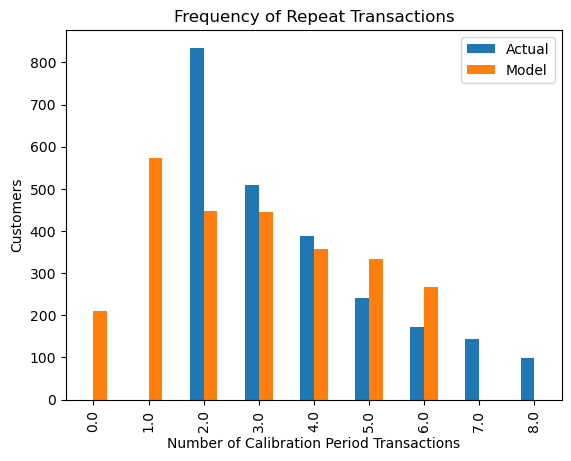

In [113]:
plot_period_transactions(bgf)
plt.show()
#turuncu renkler modelin tahmin ettiği
#mavi renkler gerçekteki değerler.


# 3. GAMMA-GAMMA Modelinin Kurulması
average profit modelleme


In [115]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(cltv_df['frequency'], cltv_df['monetary'])


<lifetimes.GammaGammaFitter: fitted with 2845 subjects, p: 3.68, q: 0.56, v: 3.59>

In [117]:
#ortalama kar
ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).head(10)


Customer ID
12347.0000    89.9925
12348.0000   114.9707
12352.0000    28.3099
12356.0000   326.4489
12358.0000   307.5914
12359.0000   354.3381
12360.0000   306.1103
12362.0000    53.2510
12363.0000   148.5819
12364.0000    85.4940
dtype: float64

In [119]:
ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).sort_values(ascending=False).head(10)


Customer ID
12590.0000   2441.7993
12435.0000   2082.4309
12409.0000   1282.0432
16984.0000   1192.6715
15749.0000   1052.2804
16253.0000    980.7660
16240.0000    932.6874
12406.0000    909.4054
13952.0000    865.7672
17672.0000    846.3962
dtype: float64

In [121]:
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary'])
cltv_df["expected_average_profit"] 
#sütun oluşturduk ve bu sütuna ortalama kar değerlerini attık.

Customer ID
12347.0000    89.9925
12348.0000   114.9707
12352.0000    28.3099
12356.0000   326.4489
12358.0000   307.5914
               ...   
18272.0000    87.8460
18273.0000    24.8422
18282.0000    49.2175
18283.0000     8.4700
18287.0000   213.7670
Name: expected_average_profit, Length: 2845, dtype: float64

In [123]:
cltv_df.sort_values("expected_average_profit", ascending=False).head(10)
#expected average profit e göre azalan sıralama yaptık.

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit
Customer ID,,,,,,,,
12590.0000,0.0000,4.3265,2,2295.5862,0.0801,0.3122,0.8935,2441.7993
12435.0000,3.8367,5.4694,2,1957.4725,0.5302,2.0735,5.9623,2082.4309
12409.0000,2.1020,3.7347,3,1230.2967,0.8141,3.1679,9.0490,1282.0432
16984.0000,0.8367,2.6735,2,1120.3375,0.7106,2.7500,7.8043,1192.6715
15749.0000,1.9796,6.7959,3,1009.5933,0.1946,0.7638,2.2066,1052.2804
16253.0000,3.8367,5.2245,2,920.9650,0.5559,2.1729,6.2424,980.7660
16240.0000,1.0816,1.5918,2,875.7300,1.1911,4.5755,12.8831,932.6874
12406.0000,3.2857,3.7551,2,853.8250,0.7314,2.8448,8.1219,909.4054
13952.0000,0.4082,4.8776,2,812.7677,0.1187,0.4633,1.3294,865.7672


In [125]:
cltv_df

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit
Customer ID,,,,,,,,
12347.0000,7.4490,7.5102,7,87.9592,0.9834,3.8660,11.2016,89.9925
12348.0000,5.7551,7.3265,4,110.6737,0.6400,2.5142,7.2766,114.9707
12352.0000,5.3061,6.0612,8,27.4428,1.2683,4.9731,14.3532,28.3099
12356.0000,6.1633,6.6531,3,312.3811,0.5993,2.3508,6.7889,326.4489
12358.0000,3.0408,3.0816,2,287.6050,0.8463,3.2823,9.3374,307.5914
...,...,...,...,...,...,...,...,...
18272.0000,4.9796,5.0408,6,85.5161,1.1952,4.6741,13.4390,87.8460
18273.0000,5.2041,5.2653,3,22.6667,0.7248,2.8344,8.1488,24.8422
18282.0000,2.4082,2.5918,2,44.5125,0.9380,3.6286,10.2921,49.2175


# 4. BG-NBD ve GG modeli ile CLTV'nin hesaplanması.

customer_lifetime methodu derki gamma gamma ve bg nbd modelini ver bununla beraber değişkenleri ver ve bana zaman periyodu ver time aylıktır.
girmiş olduğun veri aylık mı haftalık mı günlük mü bunun frekans bilgisini ver
recency ve müşteri yaşı açısından ekliyoruz bu bilgiyi haftalık olarak verdik.
verdiğimiz indirimler discount_rate.
herbir gözlem birimi için cltv hesabı yapılacaktır.


In [127]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=3,  # 3 aylık
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)

cltv.head()


Customer ID
12347.0000   1069.7452
12348.0000    887.7146
12352.0000    431.0664
12356.0000   2351.2051
12358.0000   3043.6258
Name: clv, dtype: float64

In [129]:
cltv = cltv.reset_index() 
#index atadık
cltv


,index,Customer ID,clv
0,0,12347.0000,1069.7452
1,1,12348.0000,887.7146
2,2,12352.0000,431.0664
3,3,12356.0000,2351.2051
4,4,12358.0000,3043.6258
...,...,...,...
2840,2840,18272.0000,1252.0382
2841,2841,18273.0000,214.6887
2842,2842,18282.0000,536.6882
2843,2843,18283.0000,214.6373


In [131]:
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
#cltv_df ile cltv birleştir , neye göre customer_ıd ye göre, left yani cltv_df e göre birleştir.
#how=”left”, cltv_df’e göre merge işleminin yapılmasını belirtir.

cltv_final.sort_values(by="clv", ascending=False).head(10)

#clv değeri:customer_lifetme_value fonksiyonu retorn ettiği dataframedeki
#isimlendirmeyi böyle yapmış.

#bunun sonucunda 3 aylık müşteri yaşam boyu değerine ulaştık.

#bg nbd nin  teorisinin azıcık karışabilen noktası derki senin için düzenli olan bir müşteri recency değeri
#arttıkça kendi içinde kullanıcı özelinde recency değeri arttıkça
#müşterinin satın alma olasılığı yaklaşıyordur eli kualğındadır.
#çünkü müşteri alışveriş yaptı , yaptıktan sonra kısmi churn oluyordu yani drop oluyordu
#aldıktan sonra hemen her işlemden sonra o alma duyusu tatmin olur ihtiyacı görülür vs.
#gibi sebeplerle müşteri satın almasını yaptıktan sonra drop olur kenara çekilir.
#aradan zaman geçer müşterinin tekrar satın alma ihtiyacı ortaya çıkmaya başlar
#işte bu sebeple recency ve müşteri yaşı çiftleri oldukça yüksek değerler yada
#birbirine oldukça yakın değerler


,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit,index,clv
1754,16000.0000,0.0000,0.0612,3,778.3733,2.8759,10.8428,30.0385,811.5693,1754,25790.9108
49,12435.0000,3.8367,5.4694,2,1957.4725,0.5302,2.0735,5.9623,2082.4309,49,13167.7149
2280,17084.0000,0.0000,0.7347,2,737.4375,1.4866,5.6600,15.8054,785.7015,2280,13144.0243
1873,16240.0000,1.0816,1.5918,2,875.7300,1.1911,4.5755,12.8831,932.6874,1873,12724.6042
31,12409.0000,2.1020,3.7347,3,1230.2967,0.8141,3.1679,9.0490,1282.0432,31,12297.5524
843,14096.0000,1.9796,2.0816,17,186.0934,5.0361,19.4648,55.1677,187.6099,843,10965.3057
1534,15531.0000,0.4490,0.6327,2,501.8600,1.7189,6.5359,18.2300,535.3150,1534,10328.3590
223,12762.0000,0.3469,0.5306,2,474.6300,1.7968,6.8222,19.0057,506.3732,223,10184.9360
2225,16984.0000,0.8367,2.6735,2,1120.3375,0.7106,2.7500,7.8043,1192.6715,2225,9862.0656
2774,18139.0000,0.0000,0.3878,6,234.3983,3.6197,13.7399,38.2736,239.7224,2774,9709.7899


# 5. CLTV'ye Göre Segmentlerin Oluşturulması(creating the customer segment)

In [133]:
cltv_final

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit,index,clv
0,12347.0000,7.4490,7.5102,7,87.9592,0.9834,3.8660,11.2016,89.9925,0,1069.7452
1,12348.0000,5.7551,7.3265,4,110.6737,0.6400,2.5142,7.2766,114.9707,1,887.7146
2,12352.0000,5.3061,6.0612,8,27.4428,1.2683,4.9731,14.3532,28.3099,2,431.0664
3,12356.0000,6.1633,6.6531,3,312.3811,0.5993,2.3508,6.7889,326.4489,3,2351.2051
4,12358.0000,3.0408,3.0816,2,287.6050,0.8463,3.2823,9.3374,307.5914,4,3043.6258
...,...,...,...,...,...,...,...,...,...,...,...
2840,18272.0000,4.9796,5.0408,6,85.5161,1.1952,4.6741,13.4390,87.8460,2840,1252.0382
2841,18273.0000,5.2041,5.2653,3,22.6667,0.7248,2.8344,8.1488,24.8422,2841,214.6887
2842,18282.0000,2.4082,2.5918,2,44.5125,0.9380,3.6286,10.2921,49.2175,2842,536.6882
2843,18283.0000,6.7959,6.8980,16,8.1831,2.0998,8.2499,23.8814,8.4700,2843,214.6373


In [135]:
cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])
#qcut fonksiyonu ile clv değerine göre 4 eşit parçaya ayırma işlemi gerçekleşir. 
#qcut fonksiyonu küçükten büyüğe doğru sıralama yapar. 
#0–25 arası D, 25–50 arası C, 50–75 arası B, 75–100 arası A olarak ayrılır.
cltv_final.sort_values(by="clv", ascending=False).head(50)


,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit,index,clv,segment
1754,16000.0000,0.0000,0.0612,3,778.3733,2.8759,10.8428,30.0385,811.5693,1754,25790.9108,A
49,12435.0000,3.8367,5.4694,2,1957.4725,0.5302,2.0735,5.9623,2082.4309,49,13167.7149,A
2280,17084.0000,0.0000,0.7347,2,737.4375,1.4866,5.6600,15.8054,785.7015,2280,13144.0243,A
1873,16240.0000,1.0816,1.5918,2,875.7300,1.1911,4.5755,12.8831,932.6874,1873,12724.6042,A
31,12409.0000,2.1020,3.7347,3,1230.2967,0.8141,3.1679,9.0490,1282.0432,31,12297.5524,A
843,14096.0000,1.9796,2.0816,17,186.0934,5.0361,19.4648,55.1677,187.6099,843,10965.3057,A
1534,15531.0000,0.4490,0.6327,2,501.8600,1.7189,6.5359,18.2300,535.3150,1534,10328.3590,A
223,12762.0000,0.3469,0.5306,2,474.6300,1.7968,6.8222,19.0057,506.3732,223,10184.9360,A
2225,16984.0000,0.8367,2.6735,2,1120.3375,0.7106,2.7500,7.8043,1192.6715,2225,9862.0656,A
2774,18139.0000,0.0000,0.3878,6,234.3983,3.6197,13.7399,38.2736,239.7224,2774,9709.7899,A


In [137]:
cltv_final.groupby("segment").agg(
    {"count", "mean", "sum"})


Customer ID                     recency                      T                 frequency             monetary                   expected_purc_1_week                expected_purc_1_month                 expected_purc_3_month                 expected_average_profit                       index                      clv                   
               mean count           sum    mean count       sum   mean count       sum      mean count   sum     mean count         sum                 mean count      sum                  mean count       sum                  mean count       sum                    mean count         sum      mean count      sum      mean count          sum
segment                                                                                                                                                                                                                                                                                                                                                
D        15564.5885   712 11081987.0000  4.1218   712 2934.7143 6.3470   712 4519.0816    6.7739   712  4823  48.3849   712  34450.0475               0.8767   712 624.1981                3.4395   712 2448.9352                9.9381   712 7075.8999                 51.6602   712  36782.0666 1552.3834   712  1105297  266.9286   712  190053.1618
C        15427.8368   711 10969192.0000  5.0778   711 3610.3061 6.0293   711 4286.8571    6.9353   711  4931  58.8348   711  41831.5523               1.1058   711 786.2086                4.3314   711 3079.6289               12.4890   711 8879.7118                 61.9919   711  44076.2673 1486.7750   711  1057097  579.8511   711  412274.1111
B        15257.5527   711 10848120.0000  4.2890   711 3049.4694 5.2412   711 3726.5102    5.9845   711  4255  97.1199   711  69052.2555               1.1077   711 787.5746                4.3247   711 3074.8789               12.4190   711 8829.9164                102.3786   711  72791.2159 1405.9620   711   999639  954.3151   711  678518.0434
A        14918.3010   711 10606912.0000  2.7485   711 1954.2041 3.5062   711 2492.8776    4.2616   711  3030 203.3463   711 144579.1992               1.2628   711 897.8677                4.8807   711 3470.1457               13.8528   711 9849.3510                214.7005   711 152652.0856 1242.6962   711   883557 2530.6635   711 1799301.7808

# 6. Çalışmanın Fonksiyonlaştırılması

In [138]:
def create_cltv_p(dataframe, month=3):
    # 1. Veri Ön İşleme
    dataframe.dropna(inplace=True)
    dataframe = dataframe[~dataframe["Invoice"].str.contains("C", na=False)]
    dataframe = dataframe[dataframe["Quantity"] > 0]
    dataframe = dataframe[dataframe["Price"] > 0]
    replace_with_thresholds(dataframe, "Quantity")
    replace_with_thresholds(dataframe, "Price")
    dataframe["TotalPrice"] = dataframe["Quantity"] * dataframe["Price"]
    today_date = dt.datetime(2011, 12, 11)

    cltv_df = dataframe.groupby('Customer ID').agg(
        {'InvoiceDate': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                         lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
         'Invoice': lambda Invoice: Invoice.nunique(),
         'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

    cltv_df.columns = cltv_df.columns.droplevel(0)
    cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
    cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]
    cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
    cltv_df["recency"] = cltv_df["recency"] / 7
    cltv_df["T"] = cltv_df["T"] / 7

    # 2. BG-NBD Modelinin Kurulması
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit(cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T'])

    cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                                  cltv_df['frequency'],
                                                  cltv_df['recency'],
                                                  cltv_df['T'])

    cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                                   cltv_df['frequency'],
                                                   cltv_df['recency'],
                                                   cltv_df['T'])

    cltv_df["expected_purc_3_month"] = bgf.predict(12,
                                                   cltv_df['frequency'],
                                                   cltv_df['recency'],
                                                   cltv_df['T'])

    # 3. GAMMA-GAMMA Modelinin Kurulması
    ggf = GammaGammaFitter(penalizer_coef=0.01)
    ggf.fit(cltv_df['frequency'], cltv_df['monetary'])
    cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                                 cltv_df['monetary'])

    # 4. BG-NBD ve GG modeli ile CLTV'nin hesaplanması.
    cltv = ggf.customer_lifetime_value(bgf,
                                       cltv_df['frequency'],
                                       cltv_df['recency'],
                                       cltv_df['T'],
                                       cltv_df['monetary'],
                                       time=month,  # 3 aylık
                                       freq="W",  # T'nin frekans bilgisi.
                                       discount_rate=0.01)

    cltv = cltv.reset_index()
    cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
    cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])

    return cltv_final


df = df_.copy()

cltv_final2 = create_cltv_p(df)

cltv_final2.to_csv("cltv_prediction.csv")
